In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from prediction.functions import *
from data_mani.visu import *

In [2]:
PREDICTION_MODEL = ['lasso', 'ridge', 'enet', 'random_forest', 'lgb', 'nn3']
FS_METHODS = ['all', 'granger', 'huang', 'IAMB', 'mda', 'mdi', 'MMMB', 'sfi']
EVALUATION_START = '2012-07-03'
TICKER_NAME = 'SPX Index'

## Aggregate prediction results

In [3]:
predictions_df, r2_df = aggregate_prediction_results(prediction_models=PREDICTION_MODEL,
                                                     fs_models=FS_METHODS,
                                                     evaluation_start_date=EVALUATION_START,
                                                     ticker_name=TICKER_NAME)

## R2 -  Gu, Kelly, and Xiu (2020)

In [4]:
r2_tb, agg_r2_tb = plot_df_to_table(df=r2_df,
                                    index=['fs'],
                                    columns=['model'],
                                    values=['r2'],
                                    apply_factor_to_table=100)

In [5]:
r2_tb

model,enet,lasso,lgb,nn3,random_forest,ridge
IAMB,-0.125386,0.194931,0.091345,-9.683188,-2.015956,-3.200634
MMMB,0.145037,0.260719,0.249900,-0.253133,-2.054485,-2.445411
all,0.260719,0.260719,-0.021936,-0.320744,0.618477,-610.099022
granger,0.260719,0.260719,0.226518,0.051103,0.485445,-4.891654
huang,0.216428,0.160888,0.149066,-0.124528,0.239312,0.124308
mda,0.260719,0.260719,0.320499,0.309241,-0.003625,-65.984130
mdi,0.260719,0.260719,0.262052,0.299551,-0.102545,-110.691437
sfi,0.260719,0.260719,0.289977,0.090549,-0.039325,-406.262967


In [6]:
agg_r2_tb

,sum,mean,mean_std_adj
IAMB,-14.738888,-2.456481,-0.647661
MMMB,-4.097373,-0.682895,-0.553232
all,-609.301787,-101.550298,-0.407608
granger,-3.607149,-0.601192,-0.285408
huang,0.765474,0.127579,0.975519
mda,-64.836576,-10.806096,-0.399754
mdi,-109.710940,-18.285157,-0.403914
sfi,-405.400329,-67.566721,-0.407208


## OOS portfolio returns

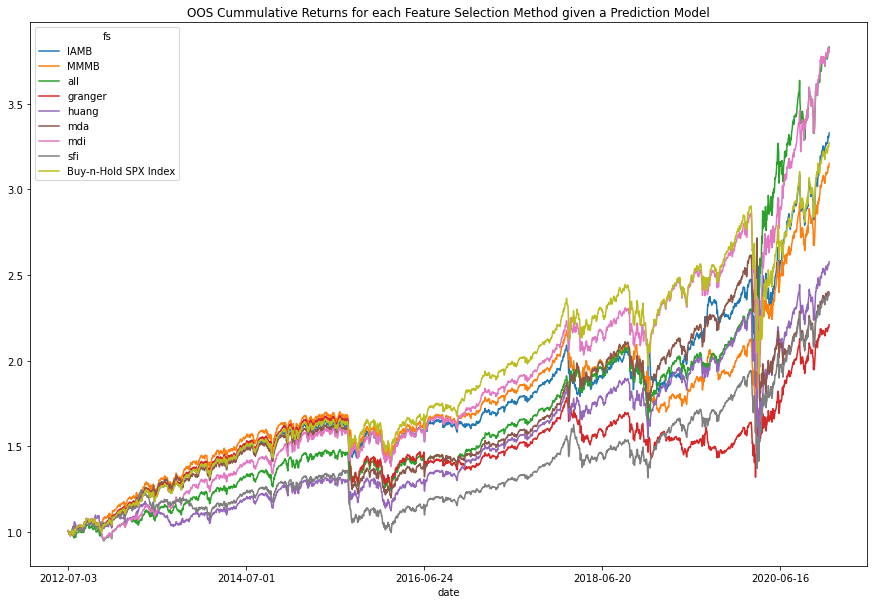

In [7]:
title = 'OOS Cummulative Returns for each Feature Selection Method given a Prediction Model'
cum_ret_fig, cum_ret, all_ret, _ = plot_ret_from_predictions(predictions_df=predictions_df,
                                                             forecast_model='random_forest',
                                                             benchmark_name='return',
                                                             benchmark_alias='Buy-n-Hold ' + TICKER_NAME,
                                                             plot_title=title)

## Sharpe ratio

In [8]:
metrics_df = aggregate_prediction_positions(predictions_df=predictions_df,
                                            forecast_model=PREDICTION_MODEL,
                                            benchmark_name='return',
                                            benchmark_alias='Buy-n-Hold ' + TICKER_NAME)

/Users/dcuoliveira/Documents/Daniel/causal_feature/src/prediction/functions.py:35: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melt_benchmark_buynhold_df = benchmark_buynhold_df.reset_index().melt('date')


ValueError: No objects to concatenate

## Ranking

In [8]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).sort_values(ascending=False)

NameError: name 'pivot_metrics_df' is not defined

### Ranking by FS vs ML

In [12]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB     0.762091  0.794736  0.815709  0.459428      0.925699 -0.197376   
MMMB     0.764929  0.913600  0.859163  0.491413      0.886952 -0.064499   
all      0.913600  0.913600  0.913600  0.317609      1.023986  0.227048   
granger  0.913600  0.913600  0.932157  0.476327      0.638345  0.252197   
huang    0.792818  0.535066  0.788681 -0.132437      0.746478  0.381632   
mda      0.913600  0.913600  0.880327  0.834678      0.692309 -0.854822   
mdi      0.913600  0.913600  0.913600  0.778677      1.018073  0.738536   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi      0.913600  0.913600  0.913600  0.724314      0.695513 -0.375178   

                 
model     value  
fs               
IAMB        NaN  
MMMB        NaN  
all         NaN  
granger     NaN  
huang       NaN  
mda         NaN  
mdi         NaN  
return   0.9136  
sfi         NaN

### Mean SR per FS method

In [13]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
return     0.913600
mdi        0.879348
all        0.718241
granger    0.687704
MMMB       0.641926
sfi        0.630908
IAMB       0.593381
mda        0.563282
huang      0.518706
dtype: float64

### Mean SR controlling by the std per FS method

In [14]:
(((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / ((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
mdi        8.563082
granger    2.435673
all        2.056736
MMMB       1.694148
huang      1.446502
IAMB       1.420800
sfi        1.254386
mda        0.805135
return          NaN
dtype: float64

## Hit rate

### Ranking

In [15]:
discrete_returns = np.where(benchmark_buynhold_df > 0, 1, 0)
discrete_positions = np.where(pivot_positions_df > 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
buys_hit_rate_per_asset = mult.sum(axis=0)

discrete_returns = np.where(benchmark_buynhold_df <= 0, 1, 0)
discrete_positions = np.where(pivot_positions_df <= 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
sells_hit_rate_per_asset = mult.sum(axis=0)

hit_rate_per_asset = (buys_hit_rate_per_asset + sells_hit_rate_per_asset) / pivot_positions_df.notnull().count(axis=0)
hit_rate_per_asset.sort_values(ascending=False)

       model          fs     
value  random_forest  mdi        0.557737
       lgb            sfi        0.556802
                      all        0.556802
       lasso          sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
                      granger    0.556802
       lgb            mdi        0.556802
       lasso          MMMB       0.556802
                      all        0.556802
       enet           sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
                      granger    0.556802
                      all        0.556802
       random_forest  huang      0.556335
       nn3            mda        0.555400
       lgb            granger    0.555400
                      MMMB       0.554932
       lasso          IAMB       0.553997
       nn3            mdi        0.553997
       enet           MMMB       0.553530
       lgb            huang      0.551660
    

### Ranking by FS vs ML

In [16]:
hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                      
model        enet     lasso       lgb       nn3 random_forest     ridge
fs                                                                     
IAMB     0.550725  0.553997  0.550725  0.534829      0.545115  0.502571
MMMB     0.553530  0.556802  0.554932  0.534829      0.546050  0.501169
all      0.556802  0.556802  0.556802  0.524544      0.548387  0.513324
granger  0.556802  0.556802  0.555400  0.540907      0.540907  0.504441
huang    0.549790  0.541842  0.551660  0.499766      0.556335  0.531089
mda      0.556802  0.556802  0.550725  0.555400      0.550257  0.475923
mdi      0.556802  0.556802  0.556802  0.553997      0.557737  0.511454
sfi      0.556802  0.556802  0.556802  0.547452      0.547920  0.499766

### Mean Hit rate per FS method

In [17]:
hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
mdi        0.548933
sfi        0.544257
all        0.542777
granger    0.542543
MMMB       0.541219
mda        0.540985
IAMB       0.539660
huang      0.538414
dtype: float64

 ### Mean Hit rate controlling by the std per FS method

In [18]:
(hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
mdi        29.826108
all        28.437438
IAMB       27.837764
granger    26.932352
huang      25.755484
MMMB       25.509747
sfi        24.461566
mda        16.902463
dtype: float64

## Maximum drawdown

### Rank

In [19]:
cum_prod_df = (1 + pivot_metrics_df).cumprod()
previous_peaks_df =  cum_prod_df.cummax()
drawdown_df = (cum_prod_df - previous_peaks_df)/previous_peaks_df
drawdown_df.min().sort_values(ascending=False)

       model          fs     
value  random_forest  all       -0.214737
       nn3            sfi       -0.219324
       random_forest  IAMB      -0.253855
                      granger   -0.260240
                      MMMB      -0.271659
       nn3            mdi       -0.278116
       random_forest  sfi       -0.294094
                      mdi       -0.321627
       ridge          mdi       -0.324908
       lgb            huang     -0.337904
       enet           MMMB      -0.337904
       lasso          IAMB      -0.337904
       nn3            MMMB      -0.337904
       lgb            IAMB      -0.337904
       enet           huang     -0.337904
       nn3            mda       -0.337904
       random_forest  huang     -0.337904
       lgb            sfi       -0.337904
                      MMMB      -0.337904
       lasso          sfi       -0.337904
       lgb            all       -0.337904
       lasso          mdi       -0.337904
                      mda       -0.337904
    

### Rank by FS vs ML

In [20]:
drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB    -0.337904 -0.337904 -0.337904 -0.443924     -0.253855 -0.467250   
MMMB    -0.337904 -0.337904 -0.337904 -0.337904     -0.271659 -0.400009   
all     -0.337904 -0.337904 -0.337904 -0.388233     -0.214737 -0.391322   
granger -0.337904 -0.337904 -0.337904 -0.337904     -0.260240 -0.435665   
huang   -0.337904 -0.337904 -0.337904 -0.443924     -0.337904 -0.428313   
mda     -0.337904 -0.337904 -0.337904 -0.337904     -0.350534 -0.755698   
mdi     -0.337904 -0.337904 -0.337904 -0.278116     -0.321627 -0.324908   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi     -0.337904 -0.337904 -0.337904 -0.219324     -0.294094 -0.690154   

                   
model       value  
fs                 
IAMB          NaN  
MMMB          NaN  
all           NaN  
granger       NaN  
huang         NaN  
mda           NaN  
mdi           NaN  
return  -0.337904  
sfi           NaN

### Mean Max drawdown per FS method

In [21]:
drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
mdi       -0.323060
all       -0.334667
MMMB      -0.337214
return    -0.337904
granger   -0.341253
IAMB      -0.363123
sfi       -0.369547
huang     -0.370642
mda       -0.409641
dtype: float64

### Mean Max drawdown controlling by the std per FS method

In [22]:
(drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
sfi        -2.256926
mda        -2.415228
IAMB       -4.595480
all        -5.227423
granger    -6.124805
huang      -7.273538
MMMB       -8.305316
mdi       -13.937210
return           NaN
dtype: float64

## Probability of Backtest Overfitting (PBO) Bailey et al. (2013)